# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Import Library

In [108]:
import pandas as pd
import numpy as np
from scipy import stats


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("seaborn")

import pycountry_convert as pc

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [109]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.sample(10)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
36720,2,Mobile,RoundTrip,27,5,8,Mon,DMKHND,Japan,0,1,0,7.57,0
38614,1,Internet,RoundTrip,111,5,15,Tue,HKTTPE,Taiwan,1,0,1,4.67,0
45779,1,Internet,RoundTrip,64,6,3,Wed,DPSPVG,United States,0,0,1,5.33,0
35292,1,Internet,RoundTrip,15,5,16,Fri,BKIMEL,Malaysia,1,1,1,8.83,1
29528,2,Internet,RoundTrip,263,4,12,Fri,BKIICN,South Korea,1,1,1,6.62,1
3854,1,Internet,RoundTrip,34,17,6,Fri,CGKICN,South Korea,1,0,0,6.62,0
44907,2,Internet,RoundTrip,63,6,13,Sat,DMKPER,Australia,1,0,1,5.62,0
30786,2,Internet,RoundTrip,97,4,3,Wed,DMKKIX,Thailand,1,0,1,7.00,0
24787,3,Internet,RoundTrip,88,22,10,Thu,SGNSYD,Australia,1,1,0,8.58,0
37742,1,Mobile,RoundTrip,107,5,12,Tue,DPSPVG,China,1,0,0,5.33,1


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [111]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [112]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [113]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [114]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

### Exploratory Data Analysis

**1. Create new feature to know customer behavior to have a trip on holiday (weekend). Value 1 for weekend and 0 for another day.**

In [115]:
weekend = []

for i in range(len(df)):
    if df.flight_day[i] == 6 or df.flight_day[i] == 7:
        weekend.append(1)
    else:
        weekend.append(0)

In [116]:
df['weekend'] = weekend
df.num_passengers.value_counts()

1    31352
2    12804
3     2941
4     1784
5      561
6      289
7      114
8       89
9       66
Name: num_passengers, dtype: int64

**2. Get a look at the distribution of 'weekend' variable to determine if we have a balanced dataset**

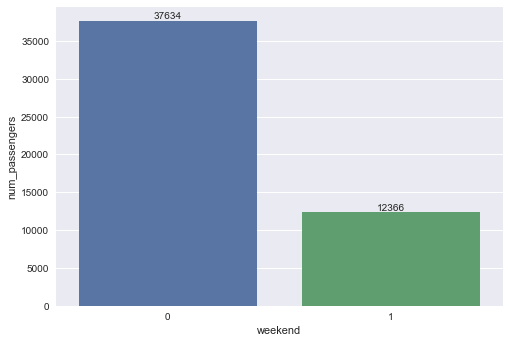

In [117]:
ax = sns.countplot(x='weekend',data=df)
ax.bar_label(ax.containers[0])
plt.ylabel('num_passengers');

Customer who flight in weekday more than weekend. So, we have imbalanced dataset.

**3. Drop columns that has many unique values**

In [118]:
df.drop('flight_day',axis=1, inplace=True)

In [119]:
df['route'].value_counts()

AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
          ... 
LBUTPE       1
CXRMEL       1
DELKBR       1
KOSSYD       1
MRUXIY       1
Name: route, Length: 799, dtype: int64

In [120]:
df.drop('route',axis=1, inplace=True)

**4. Bin column 'booking_origin' to 'booking_continent'**

In [121]:
pd.DataFrame(df['booking_origin'].value_counts()).to_html('origin.html')

In [122]:
df['booking_origin'] = df['booking_origin'].replace('Myanmar (Burma)', 'Myanmar')

In [123]:
continent = []
index = []

for i in range(len(df)):
    country = df['booking_origin'][i]
    try :
        country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
        continent_name = pc.country_alpha2_to_continent_code(country_code)
        continent.append(continent_name)
    except:
        continent.append('Others')

df['booking_continent'] = continent

In [124]:
df['booking_continent'].value_counts()

AS        29740
OC        18960
EU          578
NA          525
Others       87
AF           69
SA           41
Name: booking_continent, dtype: int64

In [125]:
df.drop('booking_origin',axis=1, inplace=True)

**5. Checking Outliers**

In [126]:
num = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']

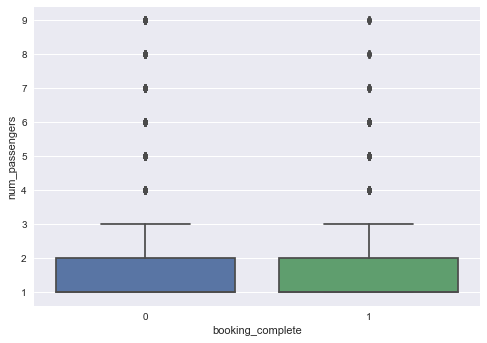

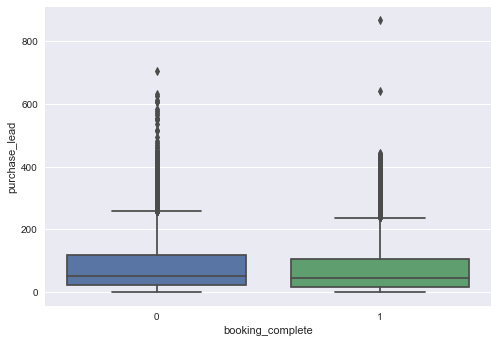

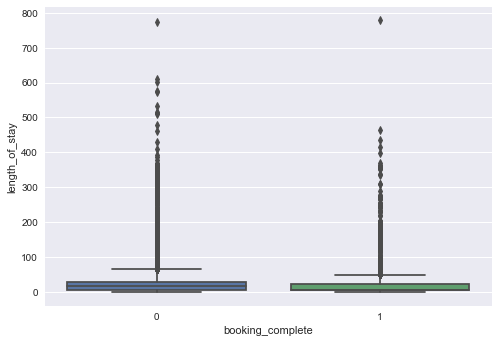

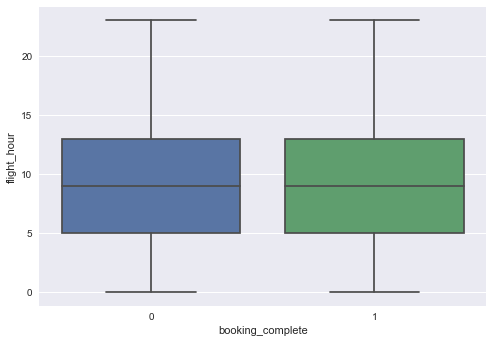

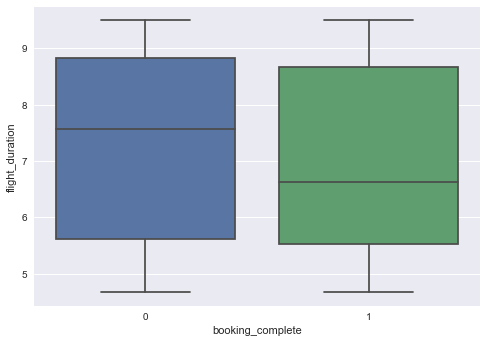

In [127]:
for feature in df[num].columns:
  sns.boxplot(x='booking_complete', y=feature, data=df)
  plt.show()

**6. Detecting Outlier using Z-score**

In [128]:
print(f'Total rows before delete outlier : {len(df)}')

filtered_entries = np.array([True] * len(df))

for col in num:
    zscore = abs(stats.zscore(df[col]))
    filtered_entries = (zscore < 3) & filtered_entries
    df = df[filtered_entries]
    
print(f'Total rows after delete outlier : {len(df)}')

Total rows before delete outlier : 50000


C:\Users\Gian\AppData\Local\Temp\ipykernel_6024\3525221275.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[filtered_entries]
C:\Users\Gian\AppData\Local\Temp\ipykernel_6024\3525221275.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[filtered_entries]
C:\Users\Gian\AppData\Local\Temp\ipykernel_6024\3525221275.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[filtered_entries]


Total rows after delete outlier : 47115


C:\Users\Gian\AppData\Local\Temp\ipykernel_6024\3525221275.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[filtered_entries]


**7. Pre-Processing and Data Cleaning of Categorical Variables**

In [129]:
label_encode = ['sales_channel']
one_hot = ['booking_continent']
                
mapping_trip_type = {
    'RoundTrip'  : 0,
    'OneWay'     : 1,
    'CircleTrip' : 2
}               

df['trip_type'] = df['trip_type'].map(mapping_trip_type)

df['sales_channel'] = preprocessing.LabelEncoder().fit_transform(df['sales_channel'])

onehots = pd.get_dummies(df['booking_continent'], prefix='booking_continent')
df = df.join(onehots)

df.drop('booking_continent', axis=1, inplace=True)

In [130]:
df.sample(10)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,weekend,booking_continent_AF,booking_continent_AS,booking_continent_EU,booking_continent_NA,booking_continent_OC,booking_continent_Others,booking_continent_SA
48878,2,1,0,7,6,8,1,1,1,8.83,1,1,0,1,0,0,0,0,0
26613,2,0,0,47,3,2,1,0,0,6.33,0,0,0,1,0,0,0,0,0
22556,2,0,0,56,22,14,1,0,0,5.62,0,0,0,0,0,0,1,0,0
19443,1,0,0,10,18,9,1,0,1,8.83,0,1,0,0,0,0,1,0,0
40036,1,0,0,36,5,8,0,0,1,8.83,0,0,0,0,0,0,1,0,0
35749,2,0,0,25,5,2,1,0,1,7.00,1,0,0,1,0,0,0,0,0
9641,2,0,0,291,26,2,1,0,0,8.83,0,0,0,0,0,0,1,0,0
31306,2,0,0,29,4,5,1,0,0,6.62,0,0,0,1,0,0,0,0,0
7157,4,0,0,75,19,1,1,0,1,8.58,0,1,0,0,0,0,1,0,0
30674,1,0,0,65,4,13,1,1,1,7.00,0,0,0,1,0,0,0,0,0


**8. Normalizing Numeric Feature**

In [131]:
df[num] = StandardScaler().fit_transform(df[num])

In [132]:
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,weekend,booking_continent_AF,booking_continent_AS,booking_continent_EU,booking_continent_NA,booking_continent_OC,booking_continent_Others,booking_continent_SA
0,0.671946,0,0,2.330417,-0.063135,-0.379058,1,0,0,-1.171115,0,1,0,0,0,0,1,0,0
1,-0.636590,0,0,0.429953,-0.017515,-1.119525,0,0,0,-1.171115,0,1,0,0,0,0,1,0,0
2,0.671946,0,0,2.089691,0.073725,1.472110,1,1,0,-1.171115,0,0,0,1,0,0,0,0,0
3,-0.636590,0,0,0.227236,0.484306,-0.934409,0,0,1,-1.171115,0,1,0,0,0,0,1,0,0
4,0.671946,0,0,-0.127517,0.073725,1.101876,1,0,1,-1.171115,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.671946,0,0,-0.646977,-0.656197,-0.008825,1,0,1,-1.104441,0,1,0,0,0,0,1,0,0
49996,-0.636590,0,0,0.417283,-0.656197,-0.934409,0,0,0,-1.104441,0,1,0,0,0,0,1,0,0
49997,-0.636590,0,0,-0.684987,-0.656197,2.397694,0,0,1,-1.104441,0,1,0,0,0,0,1,0,0
49998,-0.636590,0,0,-0.799014,-0.656197,0.361409,1,0,1,-1.104441,0,0,0,0,0,0,1,0,0


### Preparing Data for Training

**1. Separating the input and output variables**

In [133]:
x = df.drop(columns=['booking_complete'], axis=1)
y = df['booking_complete']

**2. Train and test split**

In [134]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [135]:
y_train.value_counts()

0    32081
1     5611
Name: booking_complete, dtype: int64

**3. Sampling Data**

In [136]:
sm = SMOTE(random_state = 42)
x_over, y_over = sm.fit_resample(x_train, y_train.ravel())


In [137]:
pd.Series(y_over).value_counts()

0    32081
1    32081
dtype: int64

### Defining Model

In [138]:
def score_model(x, y, model):
    pred = model.predict(x)

    print(f"Pipeline Score: {model.score(x, y)}\n")
    print(f"Accuracy: {accuracy_score(y, pred)}\n")

    print(f"Confusion Matrix:")
    sns.heatmap(confusion_matrix(y, pred), annot=True, fmt="d", cmap="ocean")
    plt.show()

    print(f"Classification Report: \n{classification_report(y, pred)}\n")

    # kfold validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    kf_scores = cross_val_score(
    model, x, y, cv=kf, n_jobs=None, scoring="accuracy"
    )
    print(f"K-Fold test: {kf_scores}")
    print(f"K-Fold Mean: {kf_scores.mean()}")

In [139]:
rf_pipe = Pipeline([("rf", RandomForestClassifier(random_state=42))])
xgb_pipe = Pipeline([("xgb", XGBClassifier(random_state=42))])
cat_pipe = Pipeline([("cat", CatBoostClassifier(random_state=42))])

pipelines = [rf_pipe, xgb_pipe, cat_pipe]

RF
Pipeline Score: 0.8111004987795819

Accuracy: 0.8111004987795819

Confusion Matrix:


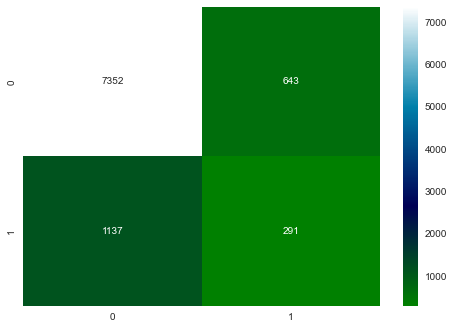

Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      7995
           1       0.31      0.20      0.25      1428

    accuracy                           0.81      9423
   macro avg       0.59      0.56      0.57      9423
weighted avg       0.78      0.81      0.79      9423


K-Fold test: [0.84509284 0.84403183 0.8397878  0.84235669 0.84341826]
K-Fold Mean: 0.8429374827529891

XGB
Pipeline Score: 0.8414517669531996

Accuracy: 0.8414517669531996

Confusion Matrix:


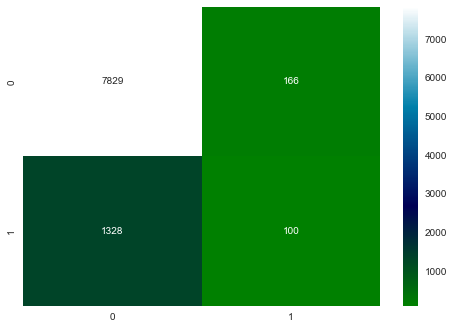

Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      7995
           1       0.38      0.07      0.12      1428

    accuracy                           0.84      9423
   macro avg       0.62      0.52      0.52      9423
weighted avg       0.78      0.84      0.79      9423


K-Fold test: [0.83607427 0.83395225 0.82970822 0.83014862 0.83333333]
K-Fold Mean: 0.8326433402602961

CAT
Learning rate set to 0.060903
0:	learn: 0.6659704	total: 129ms	remaining: 2m 8s
1:	learn: 0.6534356	total: 168ms	remaining: 1m 23s
2:	learn: 0.6339986	total: 226ms	remaining: 1m 15s
3:	learn: 0.6221203	total: 295ms	remaining: 1m 13s
4:	learn: 0.6069358	total: 361ms	remaining: 1m 11s
5:	learn: 0.5972229	total: 432ms	remaining: 1m 11s
6:	learn: 0.5884141	total: 520ms	remaining: 1m 13s
7:	learn: 0.5828763	total: 610ms	remaining: 1m 15s
8:	learn: 0.5756178	total: 716ms	remaining: 1m 18s
9:	learn: 0.5673069	total: 815ms	remaining: 1m 20s
10

154:	learn: 0.3147179	total: 9.28s	remaining: 50.6s
155:	learn: 0.3144589	total: 9.32s	remaining: 50.4s
156:	learn: 0.3127960	total: 9.38s	remaining: 50.3s
157:	learn: 0.3117354	total: 9.43s	remaining: 50.3s
158:	learn: 0.3113924	total: 9.49s	remaining: 50.2s
159:	learn: 0.3109834	total: 9.53s	remaining: 50.1s
160:	learn: 0.3108395	total: 9.59s	remaining: 50s
161:	learn: 0.3098426	total: 9.68s	remaining: 50.1s
162:	learn: 0.3097566	total: 9.72s	remaining: 49.9s
163:	learn: 0.3095020	total: 9.76s	remaining: 49.8s
164:	learn: 0.3084302	total: 9.82s	remaining: 49.7s
165:	learn: 0.3071314	total: 9.88s	remaining: 49.6s
166:	learn: 0.3067813	total: 9.93s	remaining: 49.5s
167:	learn: 0.3060240	total: 9.97s	remaining: 49.4s
168:	learn: 0.3057546	total: 10s	remaining: 49.3s
169:	learn: 0.3053386	total: 10.1s	remaining: 49.2s
170:	learn: 0.3049981	total: 10.1s	remaining: 49.1s
171:	learn: 0.3047916	total: 10.2s	remaining: 49s
172:	learn: 0.3044839	total: 10.2s	remaining: 48.9s
173:	learn: 0.3038

315:	learn: 0.2612768	total: 16.5s	remaining: 35.7s
316:	learn: 0.2611894	total: 16.5s	remaining: 35.6s
317:	learn: 0.2611366	total: 16.6s	remaining: 35.5s
318:	learn: 0.2607522	total: 16.6s	remaining: 35.5s
319:	learn: 0.2607059	total: 16.6s	remaining: 35.4s
320:	learn: 0.2606139	total: 16.7s	remaining: 35.3s
321:	learn: 0.2605200	total: 16.7s	remaining: 35.2s
322:	learn: 0.2604351	total: 16.8s	remaining: 35.1s
323:	learn: 0.2602503	total: 16.8s	remaining: 35.1s
324:	learn: 0.2600905	total: 16.9s	remaining: 35s
325:	learn: 0.2599724	total: 16.9s	remaining: 34.9s
326:	learn: 0.2598561	total: 16.9s	remaining: 34.8s
327:	learn: 0.2597354	total: 17.1s	remaining: 34.9s
328:	learn: 0.2596724	total: 17.1s	remaining: 34.9s
329:	learn: 0.2595957	total: 17.2s	remaining: 34.9s
330:	learn: 0.2595412	total: 17.2s	remaining: 34.8s
331:	learn: 0.2594238	total: 17.3s	remaining: 34.8s
332:	learn: 0.2591963	total: 17.3s	remaining: 34.7s
333:	learn: 0.2591112	total: 17.4s	remaining: 34.7s
334:	learn: 0.

475:	learn: 0.2456135	total: 25.5s	remaining: 28s
476:	learn: 0.2454294	total: 25.5s	remaining: 28s
477:	learn: 0.2453405	total: 25.6s	remaining: 28s
478:	learn: 0.2452811	total: 25.7s	remaining: 28s
479:	learn: 0.2452434	total: 25.8s	remaining: 28s
480:	learn: 0.2451768	total: 25.9s	remaining: 27.9s
481:	learn: 0.2451380	total: 26s	remaining: 28s
482:	learn: 0.2450161	total: 26.1s	remaining: 27.9s
483:	learn: 0.2449578	total: 26.2s	remaining: 27.9s
484:	learn: 0.2449092	total: 26.2s	remaining: 27.9s
485:	learn: 0.2448418	total: 26.3s	remaining: 27.9s
486:	learn: 0.2447901	total: 26.4s	remaining: 27.8s
487:	learn: 0.2447404	total: 26.5s	remaining: 27.8s
488:	learn: 0.2447040	total: 26.5s	remaining: 27.7s
489:	learn: 0.2446688	total: 26.6s	remaining: 27.7s
490:	learn: 0.2446148	total: 26.7s	remaining: 27.7s
491:	learn: 0.2445830	total: 26.8s	remaining: 27.6s
492:	learn: 0.2444824	total: 26.8s	remaining: 27.6s
493:	learn: 0.2444160	total: 26.9s	remaining: 27.6s
494:	learn: 0.2442154	tota

636:	learn: 0.2353863	total: 34.8s	remaining: 19.8s
637:	learn: 0.2353347	total: 34.8s	remaining: 19.8s
638:	learn: 0.2352279	total: 34.9s	remaining: 19.7s
639:	learn: 0.2352022	total: 34.9s	remaining: 19.6s
640:	learn: 0.2351584	total: 34.9s	remaining: 19.6s
641:	learn: 0.2350323	total: 35s	remaining: 19.5s
642:	learn: 0.2349973	total: 35s	remaining: 19.4s
643:	learn: 0.2349256	total: 35.1s	remaining: 19.4s
644:	learn: 0.2348543	total: 35.1s	remaining: 19.3s
645:	learn: 0.2347916	total: 35.1s	remaining: 19.3s
646:	learn: 0.2347680	total: 35.2s	remaining: 19.2s
647:	learn: 0.2346861	total: 35.2s	remaining: 19.1s
648:	learn: 0.2345780	total: 35.3s	remaining: 19.1s
649:	learn: 0.2345350	total: 35.3s	remaining: 19s
650:	learn: 0.2344980	total: 35.3s	remaining: 18.9s
651:	learn: 0.2344488	total: 35.4s	remaining: 18.9s
652:	learn: 0.2344216	total: 35.4s	remaining: 18.8s
653:	learn: 0.2343798	total: 35.5s	remaining: 18.8s
654:	learn: 0.2343456	total: 35.5s	remaining: 18.7s
655:	learn: 0.2343

797:	learn: 0.2277570	total: 43s	remaining: 10.9s
798:	learn: 0.2277141	total: 43.1s	remaining: 10.8s
799:	learn: 0.2276748	total: 43.1s	remaining: 10.8s
800:	learn: 0.2276416	total: 43.1s	remaining: 10.7s
801:	learn: 0.2276002	total: 43.2s	remaining: 10.7s
802:	learn: 0.2275517	total: 43.2s	remaining: 10.6s
803:	learn: 0.2274957	total: 43.3s	remaining: 10.6s
804:	learn: 0.2274191	total: 43.3s	remaining: 10.5s
805:	learn: 0.2273729	total: 43.4s	remaining: 10.4s
806:	learn: 0.2273451	total: 43.4s	remaining: 10.4s
807:	learn: 0.2273245	total: 43.5s	remaining: 10.3s
808:	learn: 0.2272877	total: 43.5s	remaining: 10.3s
809:	learn: 0.2272516	total: 43.6s	remaining: 10.2s
810:	learn: 0.2272085	total: 43.6s	remaining: 10.2s
811:	learn: 0.2271737	total: 43.6s	remaining: 10.1s
812:	learn: 0.2271126	total: 43.7s	remaining: 10s
813:	learn: 0.2270961	total: 43.7s	remaining: 9.99s
814:	learn: 0.2270671	total: 43.8s	remaining: 9.93s
815:	learn: 0.2270406	total: 43.8s	remaining: 9.87s
816:	learn: 0.22

956:	learn: 0.2216098	total: 53.4s	remaining: 2.4s
957:	learn: 0.2215529	total: 53.5s	remaining: 2.34s
958:	learn: 0.2215303	total: 53.5s	remaining: 2.29s
959:	learn: 0.2215117	total: 53.6s	remaining: 2.23s
960:	learn: 0.2214674	total: 53.7s	remaining: 2.18s
961:	learn: 0.2214467	total: 53.7s	remaining: 2.12s
962:	learn: 0.2214150	total: 53.8s	remaining: 2.07s
963:	learn: 0.2214058	total: 53.9s	remaining: 2.01s
964:	learn: 0.2213586	total: 54s	remaining: 1.96s
965:	learn: 0.2213339	total: 54s	remaining: 1.9s
966:	learn: 0.2213056	total: 54.1s	remaining: 1.85s
967:	learn: 0.2212586	total: 54.2s	remaining: 1.79s
968:	learn: 0.2212102	total: 54.2s	remaining: 1.74s
969:	learn: 0.2211417	total: 54.3s	remaining: 1.68s
970:	learn: 0.2211227	total: 54.4s	remaining: 1.62s
971:	learn: 0.2210848	total: 54.4s	remaining: 1.57s
972:	learn: 0.2210477	total: 54.5s	remaining: 1.51s
973:	learn: 0.2210267	total: 54.5s	remaining: 1.46s
974:	learn: 0.2209922	total: 54.6s	remaining: 1.4s
975:	learn: 0.22093

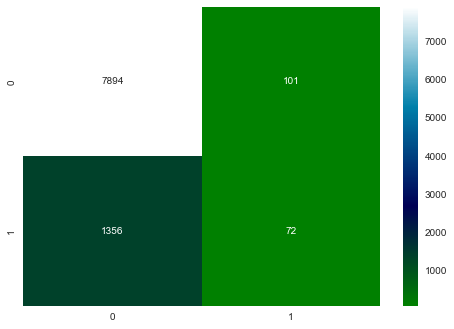

Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      7995
           1       0.42      0.05      0.09      1428

    accuracy                           0.85      9423
   macro avg       0.63      0.52      0.50      9423
weighted avg       0.79      0.85      0.79      9423


Learning rate set to 0.024407
0:	learn: 0.6770981	total: 21.5ms	remaining: 21.5s
1:	learn: 0.6603190	total: 28ms	remaining: 14s
2:	learn: 0.6449059	total: 35.7ms	remaining: 11.9s
3:	learn: 0.6303148	total: 64.4ms	remaining: 16s
4:	learn: 0.6163307	total: 70.5ms	remaining: 14s
5:	learn: 0.6036337	total: 74.9ms	remaining: 12.4s
6:	learn: 0.5914678	total: 83.9ms	remaining: 11.9s
7:	learn: 0.5798768	total: 91.2ms	remaining: 11.3s
8:	learn: 0.5689288	total: 97.9ms	remaining: 10.8s
9:	learn: 0.5604908	total: 102ms	remaining: 10.1s
10:	learn: 0.5506276	total: 108ms	remaining: 9.69s
11:	learn: 0.5414891	total: 114ms	remaining: 9.4s
12:	learn: 0.532

159:	learn: 0.3726923	total: 1.45s	remaining: 7.61s
160:	learn: 0.3725899	total: 1.46s	remaining: 7.59s
161:	learn: 0.3724161	total: 1.47s	remaining: 7.61s
162:	learn: 0.3723449	total: 1.48s	remaining: 7.59s
163:	learn: 0.3721271	total: 1.48s	remaining: 7.57s
164:	learn: 0.3720664	total: 1.49s	remaining: 7.54s
165:	learn: 0.3719384	total: 1.5s	remaining: 7.52s
166:	learn: 0.3718550	total: 1.5s	remaining: 7.5s
167:	learn: 0.3717138	total: 1.51s	remaining: 7.48s
168:	learn: 0.3715065	total: 1.52s	remaining: 7.46s
169:	learn: 0.3713731	total: 1.52s	remaining: 7.43s
170:	learn: 0.3712578	total: 1.53s	remaining: 7.41s
171:	learn: 0.3712270	total: 1.53s	remaining: 7.37s
172:	learn: 0.3710394	total: 1.54s	remaining: 7.35s
173:	learn: 0.3708921	total: 1.54s	remaining: 7.33s
174:	learn: 0.3707419	total: 1.55s	remaining: 7.31s
175:	learn: 0.3706739	total: 1.56s	remaining: 7.29s
176:	learn: 0.3705991	total: 1.56s	remaining: 7.27s
177:	learn: 0.3704630	total: 1.57s	remaining: 7.25s
178:	learn: 0.3

320:	learn: 0.3555084	total: 2.76s	remaining: 5.84s
321:	learn: 0.3553761	total: 2.77s	remaining: 5.83s
322:	learn: 0.3552971	total: 2.78s	remaining: 5.83s
323:	learn: 0.3551825	total: 2.79s	remaining: 5.82s
324:	learn: 0.3549970	total: 2.8s	remaining: 5.82s
325:	learn: 0.3549304	total: 2.81s	remaining: 5.81s
326:	learn: 0.3547864	total: 2.81s	remaining: 5.79s
327:	learn: 0.3547084	total: 2.82s	remaining: 5.78s
328:	learn: 0.3546136	total: 2.83s	remaining: 5.77s
329:	learn: 0.3544877	total: 2.84s	remaining: 5.76s
330:	learn: 0.3544140	total: 2.84s	remaining: 5.75s
331:	learn: 0.3543040	total: 2.85s	remaining: 5.73s
332:	learn: 0.3542467	total: 2.85s	remaining: 5.72s
333:	learn: 0.3541502	total: 2.86s	remaining: 5.7s
334:	learn: 0.3540610	total: 2.87s	remaining: 5.69s
335:	learn: 0.3539876	total: 2.87s	remaining: 5.68s
336:	learn: 0.3539269	total: 2.88s	remaining: 5.68s
337:	learn: 0.3538499	total: 2.89s	remaining: 5.66s
338:	learn: 0.3538032	total: 2.9s	remaining: 5.65s
339:	learn: 0.3

483:	learn: 0.3376479	total: 3.98s	remaining: 4.25s
484:	learn: 0.3375474	total: 3.99s	remaining: 4.24s
485:	learn: 0.3374699	total: 4.01s	remaining: 4.24s
486:	learn: 0.3373346	total: 4.02s	remaining: 4.23s
487:	learn: 0.3372144	total: 4.02s	remaining: 4.22s
488:	learn: 0.3371275	total: 4.03s	remaining: 4.21s
489:	learn: 0.3370441	total: 4.04s	remaining: 4.2s
490:	learn: 0.3369461	total: 4.05s	remaining: 4.19s
491:	learn: 0.3368326	total: 4.05s	remaining: 4.18s
492:	learn: 0.3367207	total: 4.06s	remaining: 4.17s
493:	learn: 0.3366235	total: 4.06s	remaining: 4.16s
494:	learn: 0.3365650	total: 4.07s	remaining: 4.15s
495:	learn: 0.3365266	total: 4.08s	remaining: 4.14s
496:	learn: 0.3364410	total: 4.08s	remaining: 4.13s
497:	learn: 0.3362877	total: 4.09s	remaining: 4.12s
498:	learn: 0.3361939	total: 4.1s	remaining: 4.11s
499:	learn: 0.3361194	total: 4.1s	remaining: 4.1s
500:	learn: 0.3360775	total: 4.11s	remaining: 4.09s
501:	learn: 0.3359988	total: 4.12s	remaining: 4.08s
502:	learn: 0.33

661:	learn: 0.3205853	total: 5.27s	remaining: 2.69s
662:	learn: 0.3204554	total: 5.28s	remaining: 2.69s
663:	learn: 0.3203576	total: 5.3s	remaining: 2.68s
664:	learn: 0.3201934	total: 5.3s	remaining: 2.67s
665:	learn: 0.3201348	total: 5.31s	remaining: 2.66s
666:	learn: 0.3200568	total: 5.32s	remaining: 2.65s
667:	learn: 0.3199165	total: 5.33s	remaining: 2.65s
668:	learn: 0.3198604	total: 5.33s	remaining: 2.64s
669:	learn: 0.3197515	total: 5.34s	remaining: 2.63s
670:	learn: 0.3197001	total: 5.34s	remaining: 2.62s
671:	learn: 0.3195752	total: 5.35s	remaining: 2.61s
672:	learn: 0.3195542	total: 5.36s	remaining: 2.6s
673:	learn: 0.3194362	total: 5.37s	remaining: 2.6s
674:	learn: 0.3193283	total: 5.37s	remaining: 2.59s
675:	learn: 0.3192791	total: 5.38s	remaining: 2.58s
676:	learn: 0.3192513	total: 5.38s	remaining: 2.57s
677:	learn: 0.3190590	total: 5.39s	remaining: 2.56s
678:	learn: 0.3189994	total: 5.4s	remaining: 2.55s
679:	learn: 0.3189157	total: 5.4s	remaining: 2.54s
680:	learn: 0.3188

822:	learn: 0.3065657	total: 6.57s	remaining: 1.41s
823:	learn: 0.3064125	total: 6.58s	remaining: 1.41s
824:	learn: 0.3063514	total: 6.6s	remaining: 1.4s
825:	learn: 0.3062990	total: 6.6s	remaining: 1.39s
826:	learn: 0.3061950	total: 6.61s	remaining: 1.38s
827:	learn: 0.3060766	total: 6.62s	remaining: 1.38s
828:	learn: 0.3059814	total: 6.63s	remaining: 1.37s
829:	learn: 0.3059359	total: 6.63s	remaining: 1.36s
830:	learn: 0.3058208	total: 6.64s	remaining: 1.35s
831:	learn: 0.3057610	total: 6.65s	remaining: 1.34s
832:	learn: 0.3056906	total: 6.66s	remaining: 1.33s
833:	learn: 0.3056335	total: 6.67s	remaining: 1.33s
834:	learn: 0.3055189	total: 6.7s	remaining: 1.32s
835:	learn: 0.3054307	total: 6.71s	remaining: 1.31s
836:	learn: 0.3053212	total: 6.71s	remaining: 1.31s
837:	learn: 0.3052700	total: 6.73s	remaining: 1.3s
838:	learn: 0.3051802	total: 6.74s	remaining: 1.29s
839:	learn: 0.3050746	total: 6.75s	remaining: 1.29s
840:	learn: 0.3049958	total: 6.76s	remaining: 1.28s
841:	learn: 0.304

983:	learn: 0.2939032	total: 8.2s	remaining: 133ms
984:	learn: 0.2938573	total: 8.21s	remaining: 125ms
985:	learn: 0.2937958	total: 8.22s	remaining: 117ms
986:	learn: 0.2937254	total: 8.24s	remaining: 109ms
987:	learn: 0.2936361	total: 8.26s	remaining: 100ms
988:	learn: 0.2935937	total: 8.27s	remaining: 92ms
989:	learn: 0.2935145	total: 8.28s	remaining: 83.6ms
990:	learn: 0.2934829	total: 8.29s	remaining: 75.3ms
991:	learn: 0.2934220	total: 8.3s	remaining: 66.9ms
992:	learn: 0.2933852	total: 8.31s	remaining: 58.6ms
993:	learn: 0.2932656	total: 8.32s	remaining: 50.2ms
994:	learn: 0.2932068	total: 8.32s	remaining: 41.8ms
995:	learn: 0.2931857	total: 8.35s	remaining: 33.5ms
996:	learn: 0.2931367	total: 8.36s	remaining: 25.2ms
997:	learn: 0.2930926	total: 8.37s	remaining: 16.8ms
998:	learn: 0.2930626	total: 8.42s	remaining: 8.43ms
999:	learn: 0.2930360	total: 8.44s	remaining: 0us
Learning rate set to 0.024407
0:	learn: 0.6770393	total: 8.46ms	remaining: 8.45s
1:	learn: 0.6600942	total: 14.

159:	learn: 0.3718584	total: 1.86s	remaining: 9.76s
160:	learn: 0.3716202	total: 1.87s	remaining: 9.74s
161:	learn: 0.3713855	total: 1.88s	remaining: 9.71s
162:	learn: 0.3711852	total: 1.89s	remaining: 9.7s
163:	learn: 0.3709653	total: 1.9s	remaining: 9.69s
164:	learn: 0.3708919	total: 1.95s	remaining: 9.84s
165:	learn: 0.3707633	total: 1.95s	remaining: 9.82s
166:	learn: 0.3706535	total: 1.97s	remaining: 9.8s
167:	learn: 0.3705494	total: 1.98s	remaining: 9.79s
168:	learn: 0.3703990	total: 1.99s	remaining: 9.76s
169:	learn: 0.3701552	total: 1.99s	remaining: 9.73s
170:	learn: 0.3700575	total: 2s	remaining: 9.71s
171:	learn: 0.3699091	total: 2.03s	remaining: 9.78s
172:	learn: 0.3697739	total: 2.04s	remaining: 9.77s
173:	learn: 0.3695628	total: 2.05s	remaining: 9.74s
174:	learn: 0.3693993	total: 2.08s	remaining: 9.8s
175:	learn: 0.3692521	total: 2.09s	remaining: 9.79s
176:	learn: 0.3691803	total: 2.1s	remaining: 9.77s
177:	learn: 0.3690090	total: 2.11s	remaining: 9.76s
178:	learn: 0.368878

333:	learn: 0.3515732	total: 3.8s	remaining: 7.57s
334:	learn: 0.3514164	total: 3.89s	remaining: 7.72s
335:	learn: 0.3512730	total: 3.9s	remaining: 7.7s
336:	learn: 0.3511839	total: 3.92s	remaining: 7.72s
337:	learn: 0.3511094	total: 3.93s	remaining: 7.7s
338:	learn: 0.3509891	total: 3.94s	remaining: 7.68s
339:	learn: 0.3508566	total: 3.95s	remaining: 7.66s
340:	learn: 0.3508056	total: 3.96s	remaining: 7.65s
341:	learn: 0.3507312	total: 3.96s	remaining: 7.63s
342:	learn: 0.3506132	total: 3.97s	remaining: 7.61s
343:	learn: 0.3505114	total: 3.98s	remaining: 7.6s
344:	learn: 0.3504112	total: 4s	remaining: 7.59s
345:	learn: 0.3503314	total: 4.09s	remaining: 7.72s
346:	learn: 0.3502272	total: 4.09s	remaining: 7.71s
347:	learn: 0.3501566	total: 4.1s	remaining: 7.69s
348:	learn: 0.3500649	total: 4.14s	remaining: 7.72s
349:	learn: 0.3500231	total: 4.15s	remaining: 7.71s
350:	learn: 0.3499372	total: 4.16s	remaining: 7.7s
351:	learn: 0.3498494	total: 4.17s	remaining: 7.68s
352:	learn: 0.3497017	

495:	learn: 0.3343815	total: 7.79s	remaining: 7.92s
496:	learn: 0.3342175	total: 7.8s	remaining: 7.9s
497:	learn: 0.3341359	total: 7.81s	remaining: 7.88s
498:	learn: 0.3340399	total: 7.83s	remaining: 7.86s
499:	learn: 0.3339362	total: 7.83s	remaining: 7.83s
500:	learn: 0.3338236	total: 7.84s	remaining: 7.81s
501:	learn: 0.3337302	total: 7.85s	remaining: 7.79s
502:	learn: 0.3336050	total: 7.86s	remaining: 7.76s
503:	learn: 0.3335279	total: 7.86s	remaining: 7.74s
504:	learn: 0.3334166	total: 7.87s	remaining: 7.71s
505:	learn: 0.3333570	total: 7.88s	remaining: 7.69s
506:	learn: 0.3332294	total: 7.89s	remaining: 7.67s
507:	learn: 0.3331050	total: 7.9s	remaining: 7.65s
508:	learn: 0.3330311	total: 7.9s	remaining: 7.62s
509:	learn: 0.3329402	total: 7.91s	remaining: 7.6s
510:	learn: 0.3328207	total: 7.92s	remaining: 7.58s
511:	learn: 0.3327211	total: 7.93s	remaining: 7.55s
512:	learn: 0.3326641	total: 7.94s	remaining: 7.53s
513:	learn: 0.3325628	total: 7.95s	remaining: 7.51s
514:	learn: 0.332

661:	learn: 0.3189515	total: 10.3s	remaining: 5.24s
662:	learn: 0.3188712	total: 10.3s	remaining: 5.22s
663:	learn: 0.3187981	total: 10.3s	remaining: 5.22s
664:	learn: 0.3187316	total: 10.3s	remaining: 5.2s
665:	learn: 0.3186350	total: 10.3s	remaining: 5.18s
666:	learn: 0.3185776	total: 10.3s	remaining: 5.17s
667:	learn: 0.3185059	total: 10.4s	remaining: 5.15s
668:	learn: 0.3184559	total: 10.4s	remaining: 5.13s
669:	learn: 0.3183895	total: 10.4s	remaining: 5.12s
670:	learn: 0.3183019	total: 10.4s	remaining: 5.09s
671:	learn: 0.3181884	total: 10.4s	remaining: 5.08s
672:	learn: 0.3180949	total: 10.4s	remaining: 5.06s
673:	learn: 0.3179996	total: 10.4s	remaining: 5.04s
674:	learn: 0.3179260	total: 10.4s	remaining: 5.02s
675:	learn: 0.3178603	total: 10.4s	remaining: 5s
676:	learn: 0.3177827	total: 10.4s	remaining: 4.99s
677:	learn: 0.3177249	total: 10.5s	remaining: 4.97s
678:	learn: 0.3176048	total: 10.5s	remaining: 4.95s
679:	learn: 0.3175370	total: 10.5s	remaining: 4.93s
680:	learn: 0.31

837:	learn: 0.3050352	total: 11.9s	remaining: 2.29s
838:	learn: 0.3049713	total: 11.9s	remaining: 2.28s
839:	learn: 0.3048942	total: 11.9s	remaining: 2.26s
840:	learn: 0.3048584	total: 11.9s	remaining: 2.25s
841:	learn: 0.3048128	total: 11.9s	remaining: 2.23s
842:	learn: 0.3047449	total: 11.9s	remaining: 2.22s
843:	learn: 0.3046757	total: 11.9s	remaining: 2.2s
844:	learn: 0.3046097	total: 11.9s	remaining: 2.19s
845:	learn: 0.3045326	total: 11.9s	remaining: 2.17s
846:	learn: 0.3044794	total: 11.9s	remaining: 2.16s
847:	learn: 0.3044154	total: 11.9s	remaining: 2.14s
848:	learn: 0.3043121	total: 12s	remaining: 2.13s
849:	learn: 0.3042597	total: 12s	remaining: 2.11s
850:	learn: 0.3042057	total: 12s	remaining: 2.1s
851:	learn: 0.3041368	total: 12s	remaining: 2.08s
852:	learn: 0.3040908	total: 12s	remaining: 2.06s
853:	learn: 0.3040424	total: 12s	remaining: 2.05s
854:	learn: 0.3040170	total: 12s	remaining: 2.03s
855:	learn: 0.3039332	total: 12s	remaining: 2.02s
856:	learn: 0.3038788	total: 1

999:	learn: 0.2939380	total: 14.2s	remaining: 0us
Learning rate set to 0.024407
0:	learn: 0.6771572	total: 17.4ms	remaining: 17.3s
1:	learn: 0.6602670	total: 23.8ms	remaining: 11.9s
2:	learn: 0.6468493	total: 30.9ms	remaining: 10.3s
3:	learn: 0.6321024	total: 38.2ms	remaining: 9.52s
4:	learn: 0.6180406	total: 52.5ms	remaining: 10.5s
5:	learn: 0.6051946	total: 57.8ms	remaining: 9.57s
6:	learn: 0.5929334	total: 63.1ms	remaining: 8.95s
7:	learn: 0.5810894	total: 69.1ms	remaining: 8.57s
8:	learn: 0.5701584	total: 80.6ms	remaining: 8.87s
9:	learn: 0.5616740	total: 86ms	remaining: 8.51s
10:	learn: 0.5515636	total: 95.2ms	remaining: 8.56s
11:	learn: 0.5424948	total: 100ms	remaining: 8.27s
12:	learn: 0.5351597	total: 108ms	remaining: 8.18s
13:	learn: 0.5268061	total: 121ms	remaining: 8.53s
14:	learn: 0.5199352	total: 130ms	remaining: 8.55s
15:	learn: 0.5126452	total: 141ms	remaining: 8.68s
16:	learn: 0.5066340	total: 152ms	remaining: 8.78s
17:	learn: 0.5011429	total: 160ms	remaining: 8.72s
18:

159:	learn: 0.3725085	total: 1.43s	remaining: 7.53s
160:	learn: 0.3724494	total: 1.44s	remaining: 7.51s
161:	learn: 0.3722505	total: 1.45s	remaining: 7.51s
162:	learn: 0.3721160	total: 1.46s	remaining: 7.5s
163:	learn: 0.3719935	total: 1.47s	remaining: 7.49s
164:	learn: 0.3718713	total: 1.49s	remaining: 7.53s
165:	learn: 0.3717212	total: 1.5s	remaining: 7.51s
166:	learn: 0.3715311	total: 1.5s	remaining: 7.49s
167:	learn: 0.3714263	total: 1.51s	remaining: 7.49s
168:	learn: 0.3712379	total: 1.52s	remaining: 7.47s
169:	learn: 0.3711496	total: 1.53s	remaining: 7.45s
170:	learn: 0.3710715	total: 1.53s	remaining: 7.42s
171:	learn: 0.3709762	total: 1.54s	remaining: 7.41s
172:	learn: 0.3709000	total: 1.55s	remaining: 7.4s
173:	learn: 0.3708027	total: 1.55s	remaining: 7.38s
174:	learn: 0.3707269	total: 1.56s	remaining: 7.36s
175:	learn: 0.3706278	total: 1.57s	remaining: 7.34s
176:	learn: 0.3704448	total: 1.58s	remaining: 7.33s
177:	learn: 0.3703047	total: 1.58s	remaining: 7.31s
178:	learn: 0.37

333:	learn: 0.3541289	total: 2.9s	remaining: 5.79s
334:	learn: 0.3540807	total: 2.91s	remaining: 5.78s
335:	learn: 0.3539426	total: 2.92s	remaining: 5.78s
336:	learn: 0.3538251	total: 2.93s	remaining: 5.77s
337:	learn: 0.3537502	total: 2.94s	remaining: 5.76s
338:	learn: 0.3536923	total: 2.95s	remaining: 5.75s
339:	learn: 0.3536042	total: 2.96s	remaining: 5.76s
340:	learn: 0.3535323	total: 2.98s	remaining: 5.77s
341:	learn: 0.3532715	total: 3s	remaining: 5.76s
342:	learn: 0.3531515	total: 3.01s	remaining: 5.77s
343:	learn: 0.3530530	total: 3.02s	remaining: 5.76s
344:	learn: 0.3529595	total: 3.03s	remaining: 5.76s
345:	learn: 0.3529163	total: 3.04s	remaining: 5.75s
346:	learn: 0.3528051	total: 3.05s	remaining: 5.74s
347:	learn: 0.3527299	total: 3.06s	remaining: 5.73s
348:	learn: 0.3526452	total: 3.06s	remaining: 5.72s
349:	learn: 0.3524969	total: 3.07s	remaining: 5.71s
350:	learn: 0.3523205	total: 3.08s	remaining: 5.7s
351:	learn: 0.3522031	total: 3.09s	remaining: 5.69s
352:	learn: 0.352

496:	learn: 0.3362216	total: 5.08s	remaining: 5.14s
497:	learn: 0.3361355	total: 5.09s	remaining: 5.13s
498:	learn: 0.3360158	total: 5.11s	remaining: 5.13s
499:	learn: 0.3358859	total: 5.12s	remaining: 5.12s
500:	learn: 0.3357925	total: 5.13s	remaining: 5.11s
501:	learn: 0.3356545	total: 5.14s	remaining: 5.1s
502:	learn: 0.3355663	total: 5.16s	remaining: 5.09s
503:	learn: 0.3354476	total: 5.18s	remaining: 5.09s
504:	learn: 0.3353271	total: 5.19s	remaining: 5.08s
505:	learn: 0.3352536	total: 5.19s	remaining: 5.07s
506:	learn: 0.3351409	total: 5.2s	remaining: 5.06s
507:	learn: 0.3350356	total: 5.22s	remaining: 5.05s
508:	learn: 0.3349463	total: 5.22s	remaining: 5.04s
509:	learn: 0.3348340	total: 5.23s	remaining: 5.03s
510:	learn: 0.3347506	total: 5.25s	remaining: 5.02s
511:	learn: 0.3345986	total: 5.26s	remaining: 5.01s
512:	learn: 0.3345309	total: 5.28s	remaining: 5.01s
513:	learn: 0.3344502	total: 5.31s	remaining: 5.02s
514:	learn: 0.3343055	total: 5.33s	remaining: 5.02s
515:	learn: 0.

656:	learn: 0.3206933	total: 7.92s	remaining: 4.13s
657:	learn: 0.3205716	total: 7.94s	remaining: 4.13s
658:	learn: 0.3204428	total: 7.95s	remaining: 4.11s
659:	learn: 0.3203353	total: 7.96s	remaining: 4.1s
660:	learn: 0.3202731	total: 7.97s	remaining: 4.09s
661:	learn: 0.3202005	total: 7.98s	remaining: 4.07s
662:	learn: 0.3201249	total: 7.99s	remaining: 4.06s
663:	learn: 0.3200257	total: 8s	remaining: 4.05s
664:	learn: 0.3199626	total: 8.02s	remaining: 4.04s
665:	learn: 0.3198644	total: 8.02s	remaining: 4.02s
666:	learn: 0.3197368	total: 8.04s	remaining: 4.01s
667:	learn: 0.3195757	total: 8.05s	remaining: 4s
668:	learn: 0.3194901	total: 8.06s	remaining: 3.99s
669:	learn: 0.3193569	total: 8.07s	remaining: 3.97s
670:	learn: 0.3192654	total: 8.08s	remaining: 3.96s
671:	learn: 0.3191800	total: 8.09s	remaining: 3.95s
672:	learn: 0.3191012	total: 8.1s	remaining: 3.93s
673:	learn: 0.3189930	total: 8.11s	remaining: 3.92s
674:	learn: 0.3189223	total: 8.12s	remaining: 3.91s
675:	learn: 0.318785

824:	learn: 0.3066296	total: 11.1s	remaining: 2.36s
825:	learn: 0.3065971	total: 11.2s	remaining: 2.35s
826:	learn: 0.3065369	total: 11.2s	remaining: 2.33s
827:	learn: 0.3065190	total: 11.2s	remaining: 2.32s
828:	learn: 0.3064596	total: 11.2s	remaining: 2.31s
829:	learn: 0.3063747	total: 11.3s	remaining: 2.3s
830:	learn: 0.3063020	total: 11.3s	remaining: 2.29s
831:	learn: 0.3061864	total: 11.3s	remaining: 2.28s
832:	learn: 0.3060410	total: 11.4s	remaining: 2.28s
833:	learn: 0.3058686	total: 11.4s	remaining: 2.26s
834:	learn: 0.3058131	total: 11.4s	remaining: 2.25s
835:	learn: 0.3056956	total: 11.4s	remaining: 2.23s
836:	learn: 0.3056544	total: 11.4s	remaining: 2.22s
837:	learn: 0.3055808	total: 11.4s	remaining: 2.2s
838:	learn: 0.3054768	total: 11.4s	remaining: 2.19s
839:	learn: 0.3053896	total: 11.5s	remaining: 2.18s
840:	learn: 0.3053203	total: 11.5s	remaining: 2.17s
841:	learn: 0.3052466	total: 11.5s	remaining: 2.15s
842:	learn: 0.3051193	total: 11.5s	remaining: 2.14s
843:	learn: 0.

989:	learn: 0.2939641	total: 14.8s	remaining: 150ms
990:	learn: 0.2938922	total: 14.8s	remaining: 135ms
991:	learn: 0.2938390	total: 14.8s	remaining: 120ms
992:	learn: 0.2937626	total: 14.9s	remaining: 105ms
993:	learn: 0.2936763	total: 14.9s	remaining: 90ms
994:	learn: 0.2935566	total: 14.9s	remaining: 75ms
995:	learn: 0.2934655	total: 14.9s	remaining: 60ms
996:	learn: 0.2934250	total: 14.9s	remaining: 45ms
997:	learn: 0.2934151	total: 15s	remaining: 30ms
998:	learn: 0.2933546	total: 15s	remaining: 15ms
999:	learn: 0.2933104	total: 15s	remaining: 0us
Learning rate set to 0.024409
0:	learn: 0.6773655	total: 12.1ms	remaining: 12.1s
1:	learn: 0.6603826	total: 32.1ms	remaining: 16s
2:	learn: 0.6449265	total: 43.5ms	remaining: 14.4s
3:	learn: 0.6302261	total: 52.4ms	remaining: 13.1s
4:	learn: 0.6161972	total: 64.6ms	remaining: 12.8s
5:	learn: 0.6035139	total: 69.9ms	remaining: 11.6s
6:	learn: 0.5913608	total: 77.9ms	remaining: 11.1s
7:	learn: 0.5795851	total: 89.4ms	remaining: 11.1s
8:	lea

159:	learn: 0.3717725	total: 2.39s	remaining: 12.5s
160:	learn: 0.3716214	total: 2.43s	remaining: 12.7s
161:	learn: 0.3714766	total: 2.44s	remaining: 12.6s
162:	learn: 0.3712325	total: 2.45s	remaining: 12.6s
163:	learn: 0.3710314	total: 2.47s	remaining: 12.6s
164:	learn: 0.3708784	total: 2.47s	remaining: 12.5s
165:	learn: 0.3707721	total: 2.48s	remaining: 12.5s
166:	learn: 0.3707239	total: 2.5s	remaining: 12.4s
167:	learn: 0.3706512	total: 2.5s	remaining: 12.4s
168:	learn: 0.3704797	total: 2.51s	remaining: 12.3s
169:	learn: 0.3703519	total: 2.52s	remaining: 12.3s
170:	learn: 0.3702093	total: 2.53s	remaining: 12.3s
171:	learn: 0.3700735	total: 2.54s	remaining: 12.2s
172:	learn: 0.3699535	total: 2.54s	remaining: 12.2s
173:	learn: 0.3698316	total: 2.56s	remaining: 12.2s
174:	learn: 0.3696046	total: 2.6s	remaining: 12.2s
175:	learn: 0.3694269	total: 2.6s	remaining: 12.2s
176:	learn: 0.3692055	total: 2.64s	remaining: 12.3s
177:	learn: 0.3690905	total: 2.65s	remaining: 12.2s
178:	learn: 0.36

322:	learn: 0.3544126	total: 4.49s	remaining: 9.41s
323:	learn: 0.3543475	total: 4.5s	remaining: 9.38s
324:	learn: 0.3542043	total: 4.51s	remaining: 9.36s
325:	learn: 0.3541120	total: 4.52s	remaining: 9.35s
326:	learn: 0.3539834	total: 4.53s	remaining: 9.32s
327:	learn: 0.3539235	total: 4.54s	remaining: 9.3s
328:	learn: 0.3538777	total: 4.55s	remaining: 9.28s
329:	learn: 0.3537941	total: 4.56s	remaining: 9.26s
330:	learn: 0.3536976	total: 4.57s	remaining: 9.24s
331:	learn: 0.3535701	total: 4.58s	remaining: 9.21s
332:	learn: 0.3535028	total: 4.59s	remaining: 9.19s
333:	learn: 0.3534203	total: 4.6s	remaining: 9.17s
334:	learn: 0.3533229	total: 4.61s	remaining: 9.15s
335:	learn: 0.3532607	total: 4.62s	remaining: 9.13s
336:	learn: 0.3531901	total: 4.63s	remaining: 9.11s
337:	learn: 0.3531136	total: 4.64s	remaining: 9.09s
338:	learn: 0.3530358	total: 4.65s	remaining: 9.07s
339:	learn: 0.3529964	total: 4.67s	remaining: 9.06s
340:	learn: 0.3529329	total: 4.68s	remaining: 9.05s
341:	learn: 0.3

481:	learn: 0.3372734	total: 6.31s	remaining: 6.78s
482:	learn: 0.3371785	total: 6.32s	remaining: 6.76s
483:	learn: 0.3370870	total: 6.32s	remaining: 6.74s
484:	learn: 0.3369775	total: 6.33s	remaining: 6.72s
485:	learn: 0.3368980	total: 6.34s	remaining: 6.71s
486:	learn: 0.3368001	total: 6.35s	remaining: 6.69s
487:	learn: 0.3367124	total: 6.36s	remaining: 6.68s
488:	learn: 0.3365730	total: 6.38s	remaining: 6.66s
489:	learn: 0.3365079	total: 6.38s	remaining: 6.64s
490:	learn: 0.3364289	total: 6.39s	remaining: 6.63s
491:	learn: 0.3363362	total: 6.41s	remaining: 6.62s
492:	learn: 0.3362586	total: 6.42s	remaining: 6.6s
493:	learn: 0.3361367	total: 6.43s	remaining: 6.58s
494:	learn: 0.3360258	total: 6.44s	remaining: 6.57s
495:	learn: 0.3359682	total: 6.45s	remaining: 6.55s
496:	learn: 0.3358331	total: 6.46s	remaining: 6.53s
497:	learn: 0.3357381	total: 6.47s	remaining: 6.52s
498:	learn: 0.3356395	total: 6.48s	remaining: 6.5s
499:	learn: 0.3355383	total: 6.49s	remaining: 6.49s
500:	learn: 0.

661:	learn: 0.3206373	total: 7.94s	remaining: 4.05s
662:	learn: 0.3205416	total: 7.95s	remaining: 4.04s
663:	learn: 0.3204496	total: 7.96s	remaining: 4.03s
664:	learn: 0.3203486	total: 7.96s	remaining: 4.01s
665:	learn: 0.3203321	total: 7.97s	remaining: 4s
666:	learn: 0.3201875	total: 7.98s	remaining: 3.98s
667:	learn: 0.3200821	total: 7.99s	remaining: 3.97s
668:	learn: 0.3199998	total: 8s	remaining: 3.96s
669:	learn: 0.3199110	total: 8.01s	remaining: 3.94s
670:	learn: 0.3198206	total: 8.02s	remaining: 3.93s
671:	learn: 0.3196984	total: 8.03s	remaining: 3.92s
672:	learn: 0.3195619	total: 8.04s	remaining: 3.9s
673:	learn: 0.3195098	total: 8.05s	remaining: 3.89s
674:	learn: 0.3194093	total: 8.06s	remaining: 3.88s
675:	learn: 0.3193433	total: 8.07s	remaining: 3.87s
676:	learn: 0.3192529	total: 8.07s	remaining: 3.85s
677:	learn: 0.3191600	total: 8.09s	remaining: 3.84s
678:	learn: 0.3191364	total: 8.1s	remaining: 3.83s
679:	learn: 0.3190408	total: 8.11s	remaining: 3.81s
680:	learn: 0.318911

823:	learn: 0.3080966	total: 9.67s	remaining: 2.06s
824:	learn: 0.3080272	total: 9.68s	remaining: 2.05s
825:	learn: 0.3079843	total: 9.68s	remaining: 2.04s
826:	learn: 0.3079228	total: 9.69s	remaining: 2.03s
827:	learn: 0.3078378	total: 9.69s	remaining: 2.01s
828:	learn: 0.3078200	total: 9.7s	remaining: 2s
829:	learn: 0.3077390	total: 9.71s	remaining: 1.99s
830:	learn: 0.3076959	total: 9.71s	remaining: 1.98s
831:	learn: 0.3076292	total: 9.72s	remaining: 1.96s
832:	learn: 0.3075486	total: 9.73s	remaining: 1.95s
833:	learn: 0.3074753	total: 9.73s	remaining: 1.94s
834:	learn: 0.3074368	total: 9.74s	remaining: 1.93s
835:	learn: 0.3073408	total: 9.75s	remaining: 1.91s
836:	learn: 0.3072686	total: 9.76s	remaining: 1.9s
837:	learn: 0.3072199	total: 9.76s	remaining: 1.89s
838:	learn: 0.3071634	total: 9.77s	remaining: 1.87s
839:	learn: 0.3070712	total: 9.78s	remaining: 1.86s
840:	learn: 0.3070138	total: 9.78s	remaining: 1.85s
841:	learn: 0.3069732	total: 9.79s	remaining: 1.84s
842:	learn: 0.306

Learning rate set to 0.024409
0:	learn: 0.6755015	total: 18.7ms	remaining: 18.7s
1:	learn: 0.6586859	total: 34ms	remaining: 17s
2:	learn: 0.6452783	total: 44.5ms	remaining: 14.8s
3:	learn: 0.6306793	total: 50.2ms	remaining: 12.5s
4:	learn: 0.6166631	total: 65.2ms	remaining: 13s
5:	learn: 0.6038858	total: 72.9ms	remaining: 12.1s
6:	learn: 0.5913879	total: 79.6ms	remaining: 11.3s
7:	learn: 0.5796700	total: 91.5ms	remaining: 11.3s
8:	learn: 0.5685276	total: 101ms	remaining: 11.1s
9:	learn: 0.5582795	total: 111ms	remaining: 11s
10:	learn: 0.5502664	total: 124ms	remaining: 11.2s
11:	learn: 0.5409602	total: 131ms	remaining: 10.8s
12:	learn: 0.5333133	total: 141ms	remaining: 10.7s
13:	learn: 0.5250306	total: 152ms	remaining: 10.7s
14:	learn: 0.5175280	total: 161ms	remaining: 10.6s
15:	learn: 0.5101334	total: 174ms	remaining: 10.7s
16:	learn: 0.5033211	total: 188ms	remaining: 10.8s
17:	learn: 0.4969877	total: 199ms	remaining: 10.9s
18:	learn: 0.4920021	total: 208ms	remaining: 10.8s
19:	learn: 

162:	learn: 0.3704448	total: 1.26s	remaining: 6.47s
163:	learn: 0.3702554	total: 1.26s	remaining: 6.45s
164:	learn: 0.3701599	total: 1.27s	remaining: 6.43s
165:	learn: 0.3700245	total: 1.28s	remaining: 6.42s
166:	learn: 0.3699269	total: 1.28s	remaining: 6.41s
167:	learn: 0.3697791	total: 1.29s	remaining: 6.39s
168:	learn: 0.3696484	total: 1.3s	remaining: 6.38s
169:	learn: 0.3694472	total: 1.3s	remaining: 6.36s
170:	learn: 0.3694080	total: 1.31s	remaining: 6.34s
171:	learn: 0.3692602	total: 1.32s	remaining: 6.34s
172:	learn: 0.3691232	total: 1.32s	remaining: 6.34s
173:	learn: 0.3690169	total: 1.33s	remaining: 6.33s
174:	learn: 0.3688345	total: 1.34s	remaining: 6.32s
175:	learn: 0.3687096	total: 1.34s	remaining: 6.3s
176:	learn: 0.3686876	total: 1.35s	remaining: 6.28s
177:	learn: 0.3685333	total: 1.36s	remaining: 6.28s
178:	learn: 0.3684166	total: 1.36s	remaining: 6.26s
179:	learn: 0.3683171	total: 1.37s	remaining: 6.25s
180:	learn: 0.3681789	total: 1.38s	remaining: 6.23s
181:	learn: 0.3

342:	learn: 0.3509520	total: 2.5s	remaining: 4.79s
343:	learn: 0.3509325	total: 2.5s	remaining: 4.78s
344:	learn: 0.3507867	total: 2.51s	remaining: 4.77s
345:	learn: 0.3505530	total: 2.52s	remaining: 4.76s
346:	learn: 0.3504582	total: 2.52s	remaining: 4.75s
347:	learn: 0.3503733	total: 2.53s	remaining: 4.74s
348:	learn: 0.3502454	total: 2.54s	remaining: 4.73s
349:	learn: 0.3501481	total: 2.54s	remaining: 4.72s
350:	learn: 0.3500445	total: 2.55s	remaining: 4.71s
351:	learn: 0.3499446	total: 2.55s	remaining: 4.7s
352:	learn: 0.3498657	total: 2.56s	remaining: 4.69s
353:	learn: 0.3496924	total: 2.57s	remaining: 4.69s
354:	learn: 0.3495935	total: 2.57s	remaining: 4.68s
355:	learn: 0.3494665	total: 2.58s	remaining: 4.67s
356:	learn: 0.3494241	total: 2.58s	remaining: 4.66s
357:	learn: 0.3493190	total: 2.59s	remaining: 4.65s
358:	learn: 0.3492340	total: 2.6s	remaining: 4.64s
359:	learn: 0.3491607	total: 2.6s	remaining: 4.63s
360:	learn: 0.3489744	total: 2.61s	remaining: 4.62s
361:	learn: 0.348

506:	learn: 0.3333361	total: 3.59s	remaining: 3.49s
507:	learn: 0.3331936	total: 3.59s	remaining: 3.48s
508:	learn: 0.3330681	total: 3.6s	remaining: 3.47s
509:	learn: 0.3329874	total: 3.6s	remaining: 3.46s
510:	learn: 0.3329309	total: 3.61s	remaining: 3.46s
511:	learn: 0.3328199	total: 3.62s	remaining: 3.45s
512:	learn: 0.3327034	total: 3.63s	remaining: 3.44s
513:	learn: 0.3325803	total: 3.64s	remaining: 3.44s
514:	learn: 0.3325261	total: 3.65s	remaining: 3.44s
515:	learn: 0.3324249	total: 3.66s	remaining: 3.43s
516:	learn: 0.3323240	total: 3.66s	remaining: 3.42s
517:	learn: 0.3322417	total: 3.67s	remaining: 3.41s
518:	learn: 0.3321538	total: 3.67s	remaining: 3.41s
519:	learn: 0.3320480	total: 3.68s	remaining: 3.4s
520:	learn: 0.3319723	total: 3.69s	remaining: 3.39s
521:	learn: 0.3318620	total: 3.69s	remaining: 3.38s
522:	learn: 0.3317464	total: 3.7s	remaining: 3.37s
523:	learn: 0.3316753	total: 3.71s	remaining: 3.37s
524:	learn: 0.3315833	total: 3.71s	remaining: 3.36s
525:	learn: 0.33

668:	learn: 0.3181817	total: 4.67s	remaining: 2.31s
669:	learn: 0.3180729	total: 4.67s	remaining: 2.3s
670:	learn: 0.3179646	total: 4.68s	remaining: 2.29s
671:	learn: 0.3178833	total: 4.69s	remaining: 2.29s
672:	learn: 0.3178254	total: 4.69s	remaining: 2.28s
673:	learn: 0.3177176	total: 4.7s	remaining: 2.27s
674:	learn: 0.3176235	total: 4.71s	remaining: 2.27s
675:	learn: 0.3175070	total: 4.71s	remaining: 2.26s
676:	learn: 0.3174219	total: 4.72s	remaining: 2.25s
677:	learn: 0.3173492	total: 4.72s	remaining: 2.24s
678:	learn: 0.3173161	total: 4.73s	remaining: 2.24s
679:	learn: 0.3172590	total: 4.74s	remaining: 2.23s
680:	learn: 0.3171529	total: 4.75s	remaining: 2.22s
681:	learn: 0.3170700	total: 4.75s	remaining: 2.21s
682:	learn: 0.3170344	total: 4.76s	remaining: 2.21s
683:	learn: 0.3169724	total: 4.76s	remaining: 2.2s
684:	learn: 0.3168967	total: 4.77s	remaining: 2.19s
685:	learn: 0.3168237	total: 4.78s	remaining: 2.19s
686:	learn: 0.3166693	total: 4.78s	remaining: 2.18s
687:	learn: 0.3

828:	learn: 0.3050983	total: 5.72s	remaining: 1.18s
829:	learn: 0.3050252	total: 5.73s	remaining: 1.17s
830:	learn: 0.3049287	total: 5.74s	remaining: 1.17s
831:	learn: 0.3048355	total: 5.74s	remaining: 1.16s
832:	learn: 0.3047593	total: 5.75s	remaining: 1.15s
833:	learn: 0.3046811	total: 5.75s	remaining: 1.15s
834:	learn: 0.3045872	total: 5.76s	remaining: 1.14s
835:	learn: 0.3044758	total: 5.77s	remaining: 1.13s
836:	learn: 0.3044117	total: 5.77s	remaining: 1.12s
837:	learn: 0.3043250	total: 5.79s	remaining: 1.12s
838:	learn: 0.3042377	total: 5.8s	remaining: 1.11s
839:	learn: 0.3041427	total: 5.8s	remaining: 1.1s
840:	learn: 0.3040485	total: 5.81s	remaining: 1.1s
841:	learn: 0.3039912	total: 5.82s	remaining: 1.09s
842:	learn: 0.3038977	total: 5.82s	remaining: 1.08s
843:	learn: 0.3038593	total: 5.83s	remaining: 1.08s
844:	learn: 0.3037952	total: 5.83s	remaining: 1.07s
845:	learn: 0.3036966	total: 5.84s	remaining: 1.06s
846:	learn: 0.3036343	total: 5.85s	remaining: 1.06s
847:	learn: 0.30

988:	learn: 0.2936550	total: 6.81s	remaining: 75.7ms
989:	learn: 0.2936027	total: 6.81s	remaining: 68.8ms
990:	learn: 0.2935130	total: 6.82s	remaining: 61.9ms
991:	learn: 0.2934704	total: 6.83s	remaining: 55.1ms
992:	learn: 0.2934198	total: 6.83s	remaining: 48.2ms
993:	learn: 0.2933471	total: 6.84s	remaining: 41.3ms
994:	learn: 0.2932612	total: 6.84s	remaining: 34.4ms
995:	learn: 0.2932073	total: 6.85s	remaining: 27.5ms
996:	learn: 0.2930967	total: 6.86s	remaining: 20.6ms
997:	learn: 0.2930503	total: 6.86s	remaining: 13.8ms
998:	learn: 0.2929549	total: 6.87s	remaining: 6.88ms
999:	learn: 0.2928707	total: 6.88s	remaining: 0us
K-Fold test: [0.84403183 0.84615385 0.84562334 0.84607219 0.84501062]
K-Fold Mean: 0.8453783642230821



In [140]:
for pipe in pipelines:
    print(pipe.steps[0][0].upper())
    pipe.fit(x_over, y_over)
    score_model(x_test, y_test, pipe)
    print()

In [150]:
cat_params = {
"cat__depth": [4, 5, 6, 7, 8, 9, 10],
"cat__learning_rate": [0.01, 0.02, 0.03, 0.04],
"cat__iterations": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
}

cat_grid = GridSearchCV(cat_pipe, param_grid=cat_params, n_jobs=-1, scoring="accuracy", cv=5)

In [151]:
cat_grid.fit(x_train, y_train)

0:	learn: 0.6879297	total: 134ms	remaining: 1.21s
1:	learn: 0.6828011	total: 162ms	remaining: 649ms
2:	learn: 0.6778490	total: 174ms	remaining: 406ms
3:	learn: 0.6729868	total: 202ms	remaining: 303ms
4:	learn: 0.6682218	total: 215ms	remaining: 215ms
5:	learn: 0.6635451	total: 246ms	remaining: 164ms
6:	learn: 0.6589299	total: 257ms	remaining: 110ms
7:	learn: 0.6543951	total: 269ms	remaining: 67.2ms
8:	learn: 0.6499511	total: 283ms	remaining: 31.5ms
9:	learn: 0.6456043	total: 305ms	remaining: 0us


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cat',
                                        <catboost.core.CatBoostClassifier object at 0x000002C29233D820>)]),
             n_jobs=-1,
             param_grid={'cat__depth': [4, 5, 6, 7, 8, 9, 10],
                         'cat__iterations': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                             100],
                         'cat__learning_rate': [0.01, 0.02, 0.03, 0.04]},
             scoring='accuracy')

In [152]:
print("Best Hyperparameters:", cat_grid.best_params_)
print("Best f1 Score:", cat_grid.best_score_)

Best Hyperparameters: {'cat__depth': 4, 'cat__iterations': 10, 'cat__learning_rate': 0.01}
Best f1 Score: 0.851135520956543


### Features Importance

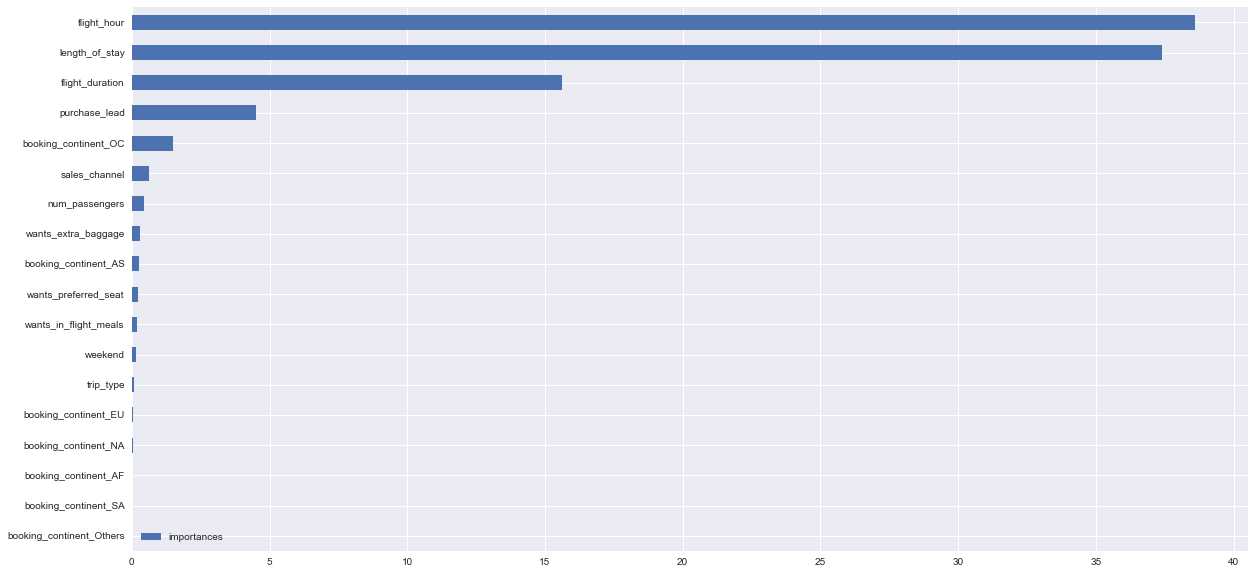

In [149]:
cb_feature_importances = pd.DataFrame(cat_pipe.steps[0][1].feature_importances_, index=x.columns, columns=['importances'])
cb_feature_importances.sort_values(by='importances', ascending=True).plot(kind='barh', figsize=(20, 10))
plt.xlabel('Ralative Importance')
plt.title('Feature Importances')
plt.show()